In [21]:
import spacy
from spacy import displacy
import pandas as pd
from tqdm import tqdm
from spacy.matcher import Matcher 
import networkx as nx
import matplotlib.pyplot as plt

nlp_es = spacy.load('es_core_news_sm') # para procesamiento de textos en español
nlp_en = spacy.load('en_core_web_sm') # para procesamiento de textos en inglés

# importar archivo con oraciones utilizando pandas (pd)
sentencias_candidatas = pd.read_csv("ejemploSPACY2.csv")
sentencias_candidatas.shape

# Realizar una muestra de oraciones
sentencias_candidatas['sentence'].sample(2)

264     examples include: frankenstein, species, mimic...
3597               cube was shot on a toronto soundstage.
Name: sentence, dtype: object

In [13]:
def get_entities(sent):
  ## Parte 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # etiqueta de dependencia del token anterior en la oración
  prv_tok_text = ""   # token anterior en la oración

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp_en(sent):
    ## Parte 2
    # Si el token es un signo de puntuación, pase al siguiente token
    if tok.dep_ != "punct":
      # comprobar: token es una palabra compuesta o no
      if tok.dep_ == "compound":
        prefix = tok.text
        # si la palabra anterior también era un 'compound', entonces agregar la palabra actual
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # comprobar: el token es un modificador o no
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # si la palabra anterior también era un 'compound', entonces agregar la palabra actual
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## Parte 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## Parte 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## Parte 5 
      # actualizar variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [15]:
def get_relation(sent):

  doc = nlp_en(sent)

  # objeto de la clase Matcher
  matcher = Matcher(nlp_en.vocab)

  # definir el patrón 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [16]:
pares_entidades = []

for i in tqdm(sentencias_candidatas["sentence"]): # con tqdm podemos mostrar una barra de progreso
  pares_entidades.append(get_entities(i))

pares_entidades[10:20]

relaciones = [get_relation(i) for i in tqdm(sentencias_candidatas['sentence'])]
pd.Series(relaciones).value_counts()[:20]


 25%|██▌       | 1085/4318 [00:16<00:45, 71.81it/s]


 52%|█████▏    | 2250/4318 [00:33<00:31, 64.67it/s]


 80%|████████  | 3461/4318 [00:49<00:10, 82.99it/s]


100%|██████████| 4318/4318 [00:59<00:00, 72.46it/s]

 11%|█▏        | 494/4318 [00:05<00:49, 76.73it/s]


 43%|████▎     | 1838/4318 [00:21<00:29, 83.68it/s]


 74%|███████▎  | 3178/4318 [00:37<00:13, 85.21it/s]


100%|██████████| 4318/4318 [00:51<00:00, 83.80it/s]


is             370
was            297
released on     87
include         73
were            71
are             71
released        40
's              38
composed by     35
have            31
has             31
became          31
become          29
released in     27
included        26
produced        22
called          22
made            20
considered      20
had             20
dtype: int64

In [17]:
# extraer sujeto
fuente = [i[0] for i in pares_entidades]

# extraer objeto
objetivo = [i[1] for i in pares_entidades]

gc_df = pd.DataFrame({'fuente':fuente, 'objetivo':objetivo, 'arista':relaciones})
gc_df

,fuente,objetivo,arista
0,connie,own,decides
1,later woman,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with
...,...,...,...
4313,confidencial,negatively film,responded
4314,le parisien,five star rating,gave
4315,museum collection,"37,000 film titles",includes
4316,predecessor,historical film 1946,was


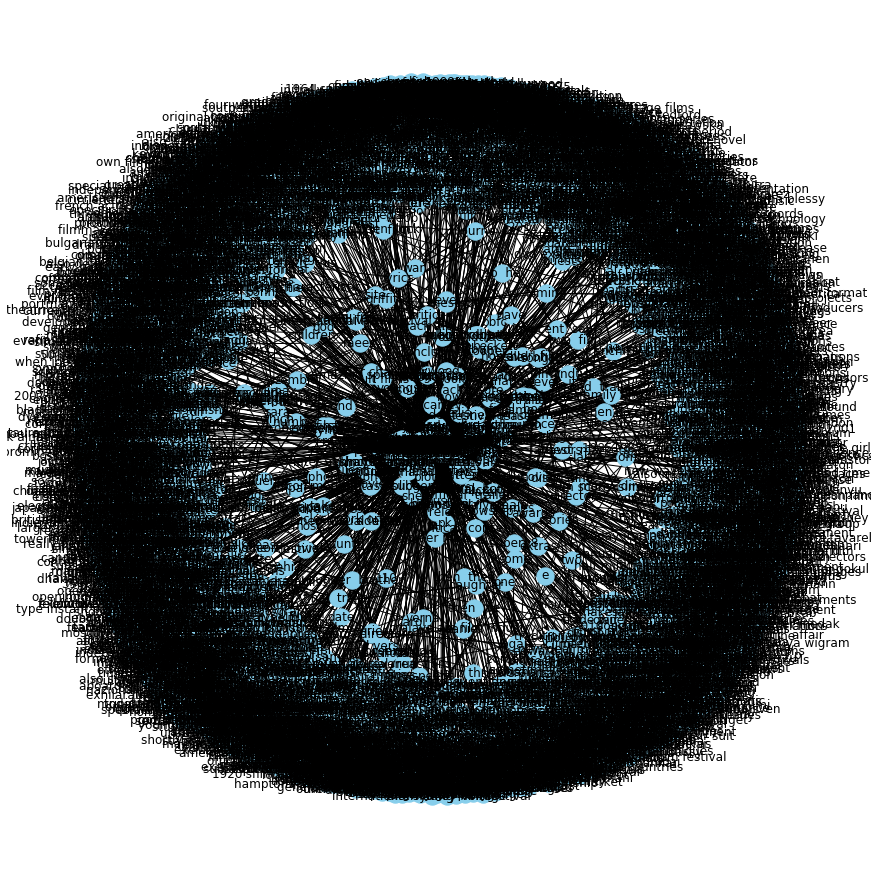

In [22]:
# crear un grafo dirigido desde un dataframe
G=nx.from_pandas_edgelist(gc_df, "fuente", "objetivo", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

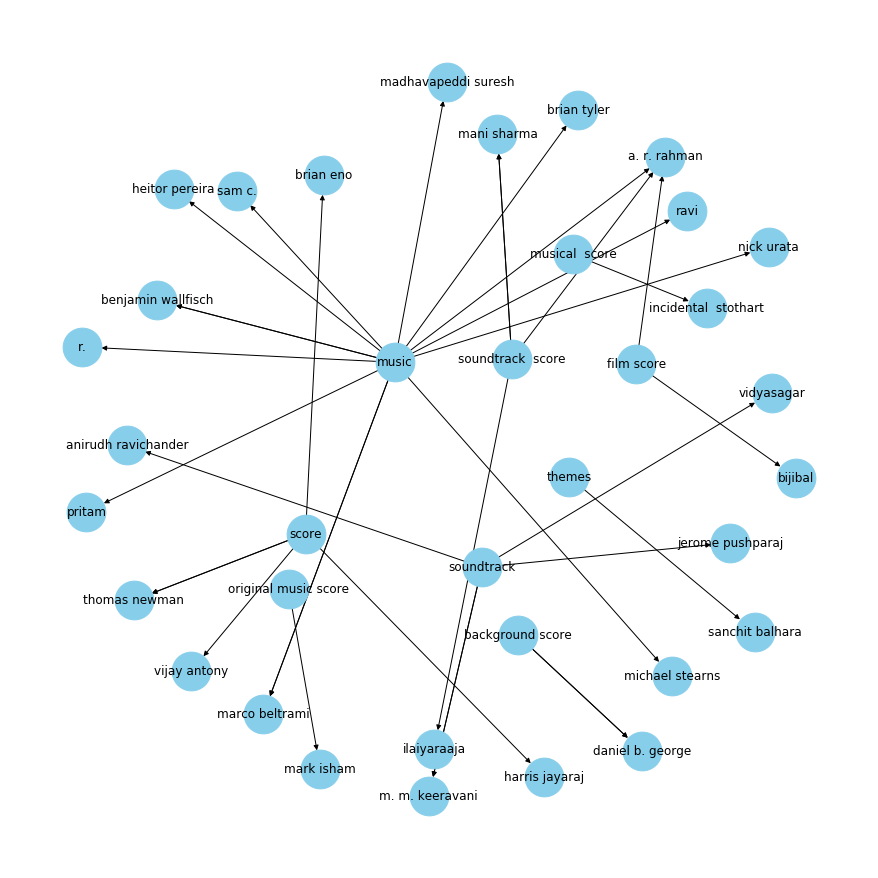

In [23]:
G=nx.from_pandas_edgelist(gc_df[gc_df['arista']=="composed by"], "fuente", "objetivo", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regula la distancia entre nodos
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

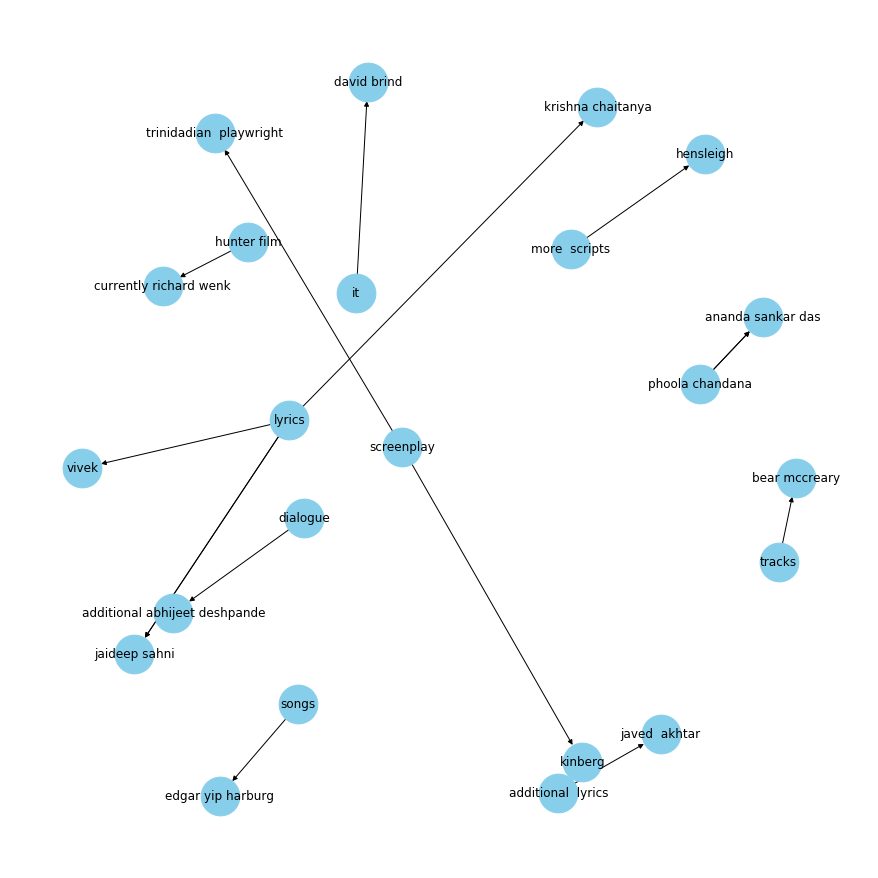

In [24]:
G=nx.from_pandas_edgelist(gc_df[gc_df['arista']=="written by"], "fuente", "objetivo", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

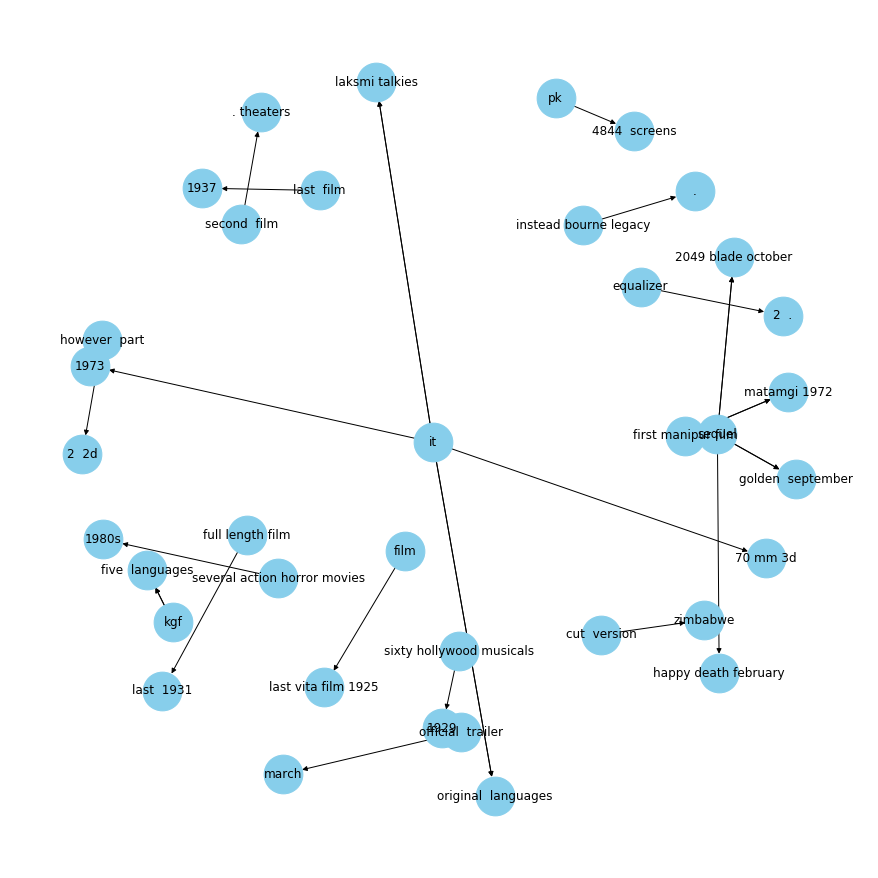

In [25]:
G=nx.from_pandas_edgelist(gc_df[gc_df['arista']=="released in"], "fuente", "objetivo", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()